In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import tqdm
import seaborn as sns

In [2]:
TENSORDTYPE = torch.float64
DEVICE = 'cpu'
LOGROOTDIR = './Plot-Figure1-v1'

All problem-specific functions accpet tensor arguments.

Take $f(t,x,a)$ as an example. We assume its inputs $t, x$ and $a$ are tensors with at least 1 dimension. All dimensions except the last are regarded as batch dimensions and are equivalent in function bodies. The outputs follow this rule too. This means even the time input $t$ and the value $f(t,x,a)$ are both scalar in their definition, we force them to be tensors in shape (1,) too.

We also adopt the sequence-first convention, which is standard in seq2seq training. Most Tensors have shape (T, M, D), where

- T : time axis
- M : batch axis
- D : original dim of this quantity

# Helper Function

In [3]:
def re_cumsum(t, dim):
    r'''torch.cumsum in reverse direction'''
    return t + torch.sum(t, dim, keepdim=True) - torch.cumsum(t, dim)

In [4]:
def format_uncertainty(value, error):
    digits = -int(math.floor(math.log10(error)))
    return "{0:.{2}f}({1:.0f})".format(value, error*10**digits, digits)

# Problem

Solve the fully coupled FBSDE
  \begin{equation*}
  \left\{
  \begin{aligned}
    X_t &= x_0 + \int_0^tb(s,X_s,Y_s,Z_s)\,ds + \int_0^t\sigma(s,X_s,Y_s,Z_s)\,dW_s,\\
    Y_t &= g(X_T) + \int_t^Tf(s,X_s,Y_s,Z_s)\,ds - \int_t^TZ_s\,dW_s.
  \end{aligned}
  \right.
  \end{equation*}
  Here, $X, Y, Z$ value in $\mathbb{R}^n, \mathbb{R}^m,\mathbb{R}^{m\times d}$.

# FBSDE

In [5]:
class FBSDE_JiLQ5(object):
    
    def __init__(self, n=5):
        self.H = 25
        self.dt = 0.004
        self.n = n
        self.m = self.n
        self.d = 1
        
        self.x0 = 1. * torch.ones(self.n).to(device=DEVICE, dtype=TENSORDTYPE)
        
    def b(self, t, x, y, z):
        return -.25*x + .5*y + .5*z.squeeze(-1)
    
    def sigma(self, t, x, y, z):
        return (.2*x + .5*y + .5*z.squeeze(-1)).unsqueeze(-1)
    
    def f(self, t, x, y, z):
        return -.5*x - .25*y + .2*z.squeeze(-1)
    
    def g(self, x):
        return -x

In [6]:
class FBSDE_JiLQ5_var(object):
    
    def __init__(self, n=5):
        self.H = 25
        self.dt = 0.004
        self.n = n
        self.m = self.n
        self.d = 1
        
        self.x0 = 1. * torch.ones(self.n).to(device=DEVICE, dtype=TENSORDTYPE)
        
    def b(self, t, x, y, z):
        return -.25*x + .5*y + .5*z.squeeze(-1)
    
    def sigma(self, t, x, y, z):
        return (.2*x + .5*y + .5*z.squeeze(-1)).unsqueeze(-1)
    
    def f(self, t, x, y, z):
        return -.5*x - .25*y + .2*z.squeeze(-1)
    
    def g(self, x):
        return -torch.ones_like(x)*x.sum(dim=-1, keepdim=True)

In [7]:
class FBSDE_HanLQ100(object):
    
    def __init__(self):
        self.H = 25
        self.dt = 0.04
        self.n = 100
        self.m = 100
        self.d = 100
        
        self.x0 = 0. * torch.ones(self.n).to(device=DEVICE, dtype=TENSORDTYPE)
        
    def b(self, t, x, y, z):
        return 2*y
    
    def sigma(self, t, x, y, z):
        return np.sqrt(2)*torch.eye(self.d).to(device=DEVICE, dtype=TENSORDTYPE)
    
    def f(self, t, x, y, z):
        return 0.*x
    
    def g(self, x):
        return -.5*x/(1+torch.sum(x*x, dim=-1, keepdim=True))

# Network

In [8]:
class YNet_FC2L(torch.nn.Module):
    
    def __init__(self, n, m, *, hidden_size):
        super().__init__()
        
        self.fcnet = torch.nn.Sequential(
            torch.nn.Linear(1+n, hidden_size, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, m, bias=True)
        )
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        z = torch.cat([t, x], dim=-1)
        return self.fcnet(z)
    
    
class ZNet_FC2L(torch.nn.Module):
    
    def __init__(self, n, m, d, *, hidden_size):
        super().__init__()
        self.m = m
        self.d = d
        
        self.fcnet = torch.nn.Sequential(
            torch.nn.Linear(1+n, hidden_size, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, m*d, bias=True)
        )
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        z = torch.cat([t, x], dim=-1)
        return self.fcnet(z).view(*x.shape[:-1], self.m, self.d)

# Solver

In [9]:
class FBSDE_BMLSolver(object):

    def __init__(self, fbsde):
        self.hidden_size = fbsde.n + 10
        self.batch_size = 64
        
        self.fbsde = fbsde
        self.ynet = YNet_FC2L(self.fbsde.n, self.fbsde.m, hidden_size=self.hidden_size)
        self.znet = ZNet_FC2L(self.fbsde.n, self.fbsde.m, self.fbsde.d, hidden_size=self.hidden_size)
        
        self.track_X_grad = False
        
    def get_optimizer(self):
        return torch.optim.Adam([
            {'params': self.ynet.parameters(), 'lr': 5e-3,},
            {'params': self.znet.parameters(), 'lr': 5e-3,}
        ])
        
    def obtain_XYZ(self, t=None, dW=None):
        if t is None:
            t = torch.tensor([self.fbsde.dt*i for i in range(1+self.fbsde.H)], dtype=TENSORDTYPE, device=DEVICE).reshape(-1,1,1).expand(-1, self.batch_size, 1)
        
        if dW is None:
            dW = torch.normal(0., np.sqrt(self.fbsde.dt), size=(self.fbsde.H, self.batch_size, self.fbsde.d), dtype=TENSORDTYPE, device=DEVICE)
        
        X = torch.empty(1+self.fbsde.H, dW.shape[1], self.fbsde.n, dtype=TENSORDTYPE, device=DEVICE)
        Y = torch.empty(1+self.fbsde.H, dW.shape[1], self.fbsde.m, dtype=TENSORDTYPE, device=DEVICE)
        Z = torch.empty(1+self.fbsde.H, dW.shape[1], self.fbsde.m, self.fbsde.d, dtype=TENSORDTYPE, device=DEVICE)
        
        X[0] = self.fbsde.x0
        Y[0] = self.ynet(t[0], X[0])
        Z[0] = self.znet(t[0], X[0])
        for i in range(self.fbsde.H):
            if self.track_X_grad is True:
                X[i+1] = X[i] + self.fbsde.dt * self.fbsde.b(t[i], X[i], Y[i], Z[i]) + (self.fbsde.sigma(t[i], X[i], Y[i], Z[i]) @ dW[i].unsqueeze(-1)).squeeze(-1)
            else:
                with torch.no_grad():
                    X[i+1] = X[i] + self.fbsde.dt * self.fbsde.b(t[i], X[i], Y[i], Z[i]) + (self.fbsde.sigma(t[i], X[i], Y[i], Z[i]) @ dW[i].unsqueeze(-1)).squeeze(-1)
            Y[i+1] = self.ynet(t[i+1], X[i+1])
            Z[i+1] = self.znet(t[i+1], X[i+1])
        
        return t, X, Y, Z, dW
    
    def calc_loss(self, t=None, dW=None, dirac=True):
        t, X, Y, Z, dW = self.obtain_XYZ(t, dW)
        if dirac:
            error = Y[0] - (self.fbsde.g(X[-1]) + self.fbsde.dt * torch.sum(self.fbsde.f(t[:-1], X[:-1], Y[:-1], Z[:-1]), dim=0) - torch.sum(Z[:-1] @ dW.unsqueeze(-1), dim=0).squeeze(-1))
            return torch.sum(error*error/dW.shape[1])
        else:
            error = Y[:-1] - (self.fbsde.g(X[-1:]) + self.fbsde.dt * re_cumsum(self.fbsde.f(t[:-1], X[:-1], Y[:-1], Z[:-1]), dim=0) - re_cumsum(Z[:-1] @ dW.unsqueeze(-1), dim=0).squeeze(-1))
            return torch.sum(error/ dW.shape[1] * error * self.fbsde.dt)

# Train

In [10]:
solver = FBSDE_BMLSolver(FBSDE_JiLQ5_var(n=5))

In [11]:
optimizer = solver.get_optimizer()
para_log = []

solver.ynet.train()
solver.znet.train()
optimizer.zero_grad()
for step in tqdm.trange(2000):
    loss = solver.calc_loss(dirac=True)
    
    para_log.append({'step': step+1, 'loss': loss.item()})
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 2000/2000 [00:18<00:00, 106.08it/s]


In [12]:
para_log = pd.DataFrame(para_log)

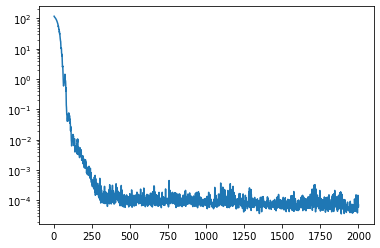

In [13]:
plt.plot(para_log.step, para_log.loss)
plt.yscale('log')

In [14]:
solver.batch_size = 512
t, X, Y, Z, dW = solver.obtain_XYZ()

In [15]:
cost = .5 * torch.sum(X[-1], dim=-1)**2 + solver.fbsde.dt * torch.sum(.25 * X[:-1] * X[:-1] + .25 * (Y[:-1] + Z[:-1].squeeze(-1)) * (Y[:-1] + Z[:-1].squeeze(-1)), dim=-1).sum(0)

In [16]:
cost.mean()

tensor(10.8286, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [17]:
format_uncertainty(Y[0].mean().item(), Y[0].std().item())

'-4.3869(2)'

## Train Multiple Models

In [18]:
def solve_JiLQ(n, dirac, repeat=10):
    r'''return cost and $p_0$.'''
    cost, p0 = [], []
    for _ in range(repeat):
        _solver = FBSDE_BMLSolver(FBSDE_JiLQ5(n=n))
        optimizer = _solver.get_optimizer()
        
        _solver.ynet.train()
        _solver.znet.train()
        optimizer.zero_grad()
        
        for step in tqdm.trange(2000):
            loss = _solver.calc_loss(dirac=dirac)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        _solver.batch_size = 512
        t, X, Y, Z, dW = _solver.obtain_XYZ()
        cost.append((.5 * torch.sum(X[-1] * X[-1], dim=-1) + _solver.fbsde.dt * torch.sum(.25 * X[:-1] * X[:-1] + .25 * (Y[:-1] + Z[:-1].squeeze(-1)) * (Y[:-1] + Z[:-1].squeeze(-1)), dim=-1).sum(0)).mean().item())
        p0.append(Y[0].mean().item())
    return cost, p0

In [19]:
res = []
for n in [5, 100]:
    for dirac in [True, False]:
        cost, p0 = solve_JiLQ(n, dirac)
        res.append({
            'n': n, 'dirac': dirac, 
            'cost': format_uncertainty(np.mean(cost), np.std(cost)),
            'p0': format_uncertainty(np.mean(p0), np.std(p0)),
        })

100%|██████████| 2000/2000 [00:53<00:00, 37.48it/s]


In [20]:
pd.DataFrame(res)

,n,dirac,cost,p0
0,5,True,2.40(1),-0.9591(4)
1,5,False,2.399(7),-0.9598(5)
2,100,True,47.9(2),-0.96(1)
3,100,False,48.0(2),-0.960(6)


In [21]:
def solve_JiLQ_var(n, dirac, repeat=10):
    r'''return cost and $p_0$.'''
    cost, p0 = [], []
    for _ in range(repeat):
        _solver = FBSDE_BMLSolver(FBSDE_JiLQ5_var(n=n))
        optimizer = _solver.get_optimizer()
        
        _solver.ynet.train()
        _solver.znet.train()
        optimizer.zero_grad()
        
        for step in tqdm.trange(2000):
            loss = _solver.calc_loss(dirac=dirac)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        _solver.batch_size = 512
        t, X, Y, Z, dW = _solver.obtain_XYZ()
        cost.append((.5 * torch.sum(X[-1], dim=-1)**2 + _solver.fbsde.dt * torch.sum(.25 * X[:-1] * X[:-1] + .25 * (Y[:-1] + Z[:-1].squeeze(-1)) * (Y[:-1] + Z[:-1].squeeze(-1)), dim=-1).sum(0)).mean().item())
        p0.append(Y[0].mean().item())
    return cost, p0

In [22]:
res = []
for n in [1, 2, 5, 10, 20]:
    for dirac in [True, False]:
        cost, p0 = solve_JiLQ_var(n, dirac)
        res.append({
            'n': n, 'dirac': dirac, 
            'cost': format_uncertainty(np.mean(cost), np.std(cost)),
            'p0': format_uncertainty(np.mean(p0), np.std(p0)),
        })

100%|██████████| 2000/2000 [00:25<00:00, 77.25it/s]


In [23]:
pd.DataFrame(res)

,n,dirac,cost,p0
0,1,True,0.478(1),-0.9584(8)
1,1,False,0.480(2),-0.959(1)
2,2,True,1.83(2),-1.8306(10)
3,2,False,1.83(2),-1.838(9)
4,5,True,10.9(2),-4.387(1)
5,5,False,10.9(1),-4.38(3)
6,10,True,42.7(8),-8.597(1)
7,10,False,42.8(7),-8.61(4)
8,20,True,169(4),-16.982(5)
9,20,False,169(4),-17.1(1)
